<a href="https://colab.research.google.com/github/bbandbass/Study/blob/main/chp4_word2vec_%EC%86%8D%EB%8F%84_%EA%B0%9C%EC%84%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word2Vec 개선

## Embedding 계층
입력층의 one-hot vector(단어 표현)와 weight matrix $W_{in}$의 matmul 계산이 단어의 수가 커지면서 상당한 계산 자원을 사용하게 되기 때문에, Embedding 계층을 도입하여 해결한다.  
사실, one-hot vector의 경우, matmul의 연산이 단지 단어 id와 일치하는 행 벡터를 추출하는 것과 동일하기 때문에, 굳이 행렬 곱 계산을 할 필요 없이, 단어 id에 해당하는 행을 추출하는 계층인 embedding 계층을 만들어 사용한다.

### Embedding 계층 구현


In [ ]:
import numpy as np
W = np.arange(21).reshape(7, 3)
print(W)
print(W[2])
print(W[5])

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]]
[6 7 8]
[15 16 17]


In [ ]:
idx = np.array([1, 0, 3, 0])
W[idx]

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

In [6]:
class Embedding:
  def __init__(self, W):
    self.params = [W]
    self.grads = [np.zeros_like(W)]
    self.idx = None

  def forward(self, idx):
    W, = self.params
    self.idx = idx
    out = W[idx]
    return out

  def backward(self, dout):
    dW = self.grads
    print(dW)
    dW[...] = 0
    print(dW)
    
    # for i, word_id in enumerate(self.idx):
    #   dW[word_id] += dout[i]
    # numpy method에는 속도와 효율을 높여주는 최적화가 적용돼 있기 때문에 
    # for문보다는 numpy의 내장 method를 사용하는 편이 더 빠르다
    np.add.at(dW, self.idx, dout) 
    # dW array의 self.idx번째 위치에 dout array의 element 순서대로 더하기

    return None

## 은닉층 이후 계산의 문제점
* 은닉층의 뉴런과 가중치 행렬 $W_{out}$의 행렬곱
* Softmax layer의 계산(Softmax의 분모 계산: 모든 어휘의 exponential값을 더하는 연산이 매우 커짐)


### negative sampling
정말 단순하게 이야기하자면 다중 분류를 이진 분류로 근사하는 것   
지금까지는 context words가 주어졌을 때 정답이 되는 단어를 높은 확률로 추측하도록 만드는 일을 했다. 예를 들어, 
* 다중 분류: context words로 'you'와 'goodbye'가 주어졌을 때, 타깃 단어가 무엇입니까?
라는 질문이었는데. 이를 yes/no만으로 답할 수 있는 이진 분류, 즉
* 이진 분류: context words로 'you'와 'goodbye'가 주어졌을 때, 타깃 단어가 'say'입니까?    

라는 질문에 답하는 신경망을 만들어내야한다. 이렇게 하면 출력층에는 뉴런을 하나만 준비하면 된다. 즉, 출력층의 해당 뉴런이 'say'의 점수를 출력하는 것이다. 따라서 은닉층과 출력층의 가중치 행렬 $W_{out}$의 행렬곱 전부를 계산하는 것이 아니라, *가중치 행렬 $W_{out}$에서 'say'에 해당하는 열 벡터만 추출하고, 이와 은닉층 뉴런과의 내적을 계산*하면 끝이다.  
  
즉, 이전까지는 출력층에서 모든 단어를 대상으로 계산을 수행했다면, 여기에서는 'say'라는 단어 하나에 주목하여 그 점수를 계산하는게 차이이다. 그리고 softmax함수가 아닌 sigmoid함수를 이용하여 그 점수를 확률로 변환하게 된다.  

추가로, 지금까지는 긍정적인 예(정답 단어)인 'say'에 대해서만 학습을 진행하여 학습을 진행하였을 때, say에 대해서 sigmoid 계층의 출력이 1에 가깝게 만들었지만, 부정적 예(say가 아닌 단어)에 대해서는 아무런 지식도 획득하지 못했다. 긍정적인 예에 대해서 출력을 1에 가깝게 하는 것을 넘어, 부정적 예에 대해서는 출력을 0에 가깝게 만들고자 하고, 이러한 결과를 내어지는 가중치가 필요하다.  

다중 분류 문제를 이진 분류로 다루려면 정답과 오답 각각에 대해 바르게 이진 분류를 할 수 있어야 한다. 따라서 긍정적 예와 부정적 예 모두를 대상으로 문제를 생각해야 한다. 하지만, 모든 부정적 예를 대상으로 이진 분류를 학습시키게 되면, 해결해고자 했던 문제인 단어 수의 증가와 함께 증가하는 계산 양에 다시 부딪히게 되기 때문에, 근사적인 해법으로 부정적인 예를 몇 개만 샘플링하여 사용하게 된다.  

정리하면, negative sampling은 긍정적 예를 타깃으로 한 경우의 loss는 물론, negative sample을 몇 개 sampling하여 그 부정적 예에 대해서도 손실을 더한 값을 최종 loss로 한다.  

이 때, negative sample들을 sampling하기 위하여, 단순히 무작위 샘플링을 하기보다는 corpus의 통계 데이터를 기초로 샘플링을 하게 된다. 구체적으로, corpus에서 자주 등장하는 단어를 많이 추출하고 드물게 등장하는 단어를 적게 추출한다. 단어 빈도를 기준으로 샘플링하기 위해서 우선, corpus에서 각 단어의 출현 빈도를 구해 확률분포로 나타낸다. 그 다음, 그 확률분포대로 단어를 샘플링한다.

In [17]:
# Embedding dot layer
# 가중치 행렬 $W_{out}$에서 'say'에 해당하는 열 벡터만 추출하고, 이와 은닉층 뉴런과의 내적을 계산을
# 하나의 계층으로 해결

class EmbeddingDot:
  def __init__(self, W):
    self.embed = Embedding(W)
    self.params = self.embed.parmas
    self.grads = self.embed.grads
    self.cache = None # 순전파 시의 계산 결과를 잠시 유지하기 위한 변수로 사용

  def forward(self, h, idx):
    target_W = self.embed.forward(idx) # W_out에서 원하는 단어 index를 받아 단어 벡터를 받아옴
    out = np.sum(target_W * h, axis = 1) # target_W와 은닉층의 내적

    self.cache = (h, target_W)
    return out

  def backward(self, dout):
    h, target_W = self.cache
    dout = dout.reshape(dout.shape[0], 1) # dout을 벡터 형태로

    dtarget_W = dout * h # target_W와 h의 내적에 대한 backward 계산을 하기 때문에 dout과 h를 곱해준다
    self.embed.backward(dtarget_W) 
    dh = dout * target_W # target_W와 h의 내적에 대한 backward 계산을 하기 때문에 dout과 target_W를 곱해준다
    return dh

In [10]:
# negative sampling 기법 중 확률분포에 따라 샘플링하는 부분의 구현

# 0 ~ 9까지의 숫자 random sampling
print(np.random.choice(10))

# words에서 random sampling
words = ['you', 'say', 'goodbye', 'I', 'hello', '.']
print(np.random.choice(words))

# 5개만 무작위로 샘플링(중복 있음, 복원 추출)
print(np.random.choice(words, size = 5))

# 5개만 무작위로 샘플링(중복 없음, 비복원 추출)
print(np.random.choice(words, size = 5, replace = False))

# 확률분포에 따라 샘플링
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
print(np.random.choice(words, p = p))

7
you
['you' '.' '.' 'hello' 'hello']
['you' 'goodbye' 'say' 'hello' '.']
you


하지만, word2vec의 negative sampling에서는 앞의 확률분포에서 한 가지를 수정하여, 기본 확률분포에 0.75를 제곱하여 사용한다.

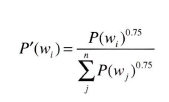

이는, 0.75를 제곱하는 것이 원래 확률이 낮은 단어의 확률을 살짝 높여 출현 확률이 낮은 단어를 버리지 않게 해주기 때문이다.  
하지만, 0.75라는 수치에 어떤 이론적인 근거나, 의미는 없기 대문에 다른 값으로 설정해도 된다.

In [11]:
# 0.75를 제곱하는 것이 원래 확률이 낮은 단어의 확률을 살짝 높여 출현 확률이 낮은 단어를 버리지 않게 해주는지 확인
p = [0.7, 0.29, 0.01]
new_p = np.power(p, 0.75)
new_p /= np.sum(new_p)
print(new_p)

[0.64196878 0.33150408 0.02652714]


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import sys
sys.path.append('..')
%cd /content/drive/MyDrive/밑바닥부터 시작하는 딥러닝2/ch04
from negative_sampling_layer import UnigramSampler, SigmoidWithLoss
# UnigramSampler는 초기화 시 단어 ID 목록인 corpus, 확률분포에 제곱할 값인 power(0.75), 
# 그리고 negative sampling을 할 수인 sample_size, 3개를 인수로 받아 negative sampling을 해준다.

corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0]) # 긍정적인 예
# 긍정적인 예 각각에 대해서 2개씩 negative sampling
negative_sample = sampler.get_negative_sample(target) 
print(negative_sample)

/content/drive/MyDrive/밑바닥부터 시작하는 딥러닝2/ch04
[[0 3]
 [2 0]
 [3 4]]


첫번째 긍정적인 예 1에 대해서는 부정적 예로 0과 3이, 3에 대해서는 0과 1이, 0에 대해서는 1과 2가 뽑혔다. 실행할 때마다 결과가 달라질 수 있다.

In [21]:
class NegativeSamplingLoss:
  def __init__(self, W, corpus, power = 0.75, sample_size = 5):
    self.sample_size = sample_size
    self.sampler = UnigramSampler(corpus, power, sample_size)
    self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
    self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
    # loss_layer, embed_dot_layer 모두에 sample_size + 1개의 layer 생성
    # 이는, 부정적 예를 다루는 layer가 sample_size만큼 필요하고, 긍정적 예를 위한 layer가 하나 필요하기 때문이다
    self.params, self.grads = [], []
    for layer in self.embed_dot_layers:
      self.parmas += layer.params
      self.grads += layer.grads

  def forward(self, h, target):
    batch_size = target.shape[0]
    negative_sample = self.sampler.get_negative_sample(target)
    # 긍정적인 예에 대해 부정적인 예를 5개씩 sampling

    # 긍정적인 예 순잔파
    score = self.embed_dot_layers[0].forward(h, target)
    correct_label = np.ones(batch_size, dtype = 'np.int32')
    loss = self.loss_layers[0].forward(score, correct_label)
    # loss가 1에 가까워지게 하기 위해

    # 부정적인 예 순전파
    negative_label = np.zeros(batch_size, dtype = 'np.int32')
    for i in range(self.sample_size):
      negative_target = negative_sample[:, i] # negative sample의 i번째 열
      score = self.embed_dot_layers[1 + i].forward(h, negative_target)
      loss += self.loss_layers[1 + i].forward(score, negative_label) 
      # loss가 0과 가까워지게 하기 위해

    return loss

  def backward(self, dout = 1):
    dh = 0
    for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
      dscore = l0.backward(dout) # sigmoid에서 backward 
      dh += ll.backward(dscore) # embed_dot_layers에서 backward
      # 은닉층의 뉴런이 순전파 시에 여러 개로 복사되었기 때문에 repeat node에 해당
      # 따라서 역전파 때는 여러 개의 기울기 값을 더해준다.

    return dh

# 개선된 word2vec 학습

## CBOW 모델 구현
Embedding 계층과 negative sampling loss 계층을 적용하여 이전의 단순한 SimpleCBOW 클래스 개선, 나아가 window_size를 임의로 조절할 수 있도록 확장

In [23]:
%cd /content/drive/MyDrive/밑바닥부터 시작하는 딥러닝2/common
from common.layers import Embedding

class CBOW:
  def __init__(self, vocab_size, hidden_size, window_size, corpus):
    V, H = vocab_size, hidden_size
    
    # 가중치 초기화
    W_in = 0.01 * np.random.randn(V, H).astype('f')
    W_out = 0.01 * np.random.randn(V, H).astype('f')
    # SimpleCBOW 클래스에서는 입력층의 가중치와 출력 층의 가중치의 형상이 달라서 출력층의 가중치에서는
    # 단어 벡터가 열 방향으로 배치되었다. 한편 개선된 CBOW의 클래스의 출력층 가중치는 입력층 가중치와
    # 같은 형상으로 단어 벡터가 행 방향에 배치된다. 이는 NegativeSamplingLoss 클래스에서 
    # embedding layer를 사용하기 때문이다.

    # layer 생성
    self.in_layers = []
    for i in range(2 * window_size):
      layer = Embedding(W_in)
      self.in_layers.append(layer)
    self.ns_loss = NegativeSamplingloss(W_out, corpus, power = 0.75, sample_size = 5)

    # 모든 가중치와 기울기를 배열에 모은다.
    layers = self.in_layers + [self.ns_loss]
    self.params, self.grads = [], []
    for layer in layers:
      self.params += layer.parmas
      self.grads += layer.grads

    # 인스턴스 변수에 단어의 분산 표현 저장
    self.word_vecs = W_in

  def forward(self, contexts, target):
    h = 0 
    for i, layer in enumerate(self.in_layers):
      h += layer.forward(contexts[:, i])
    h *= 1 / len(self.in_layers)
    loss = self.ns_loss.forward(h, target)
    return loss

  def backward(self, dout = 1):
    dout = self.ns_loss.backward(dout)
    dout *= 1 / len(self.in_layers)
    for layer in self.in_layers:
      layer.backward(dout)
    return None

/content/drive/MyDrive/밑바닥부터 시작하는 딥러닝2/common


In [ ]:
# coding: utf-8
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ===============================================
# config.GPU = True
# ===============================================
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import create_contexts_target, to_cpu, to_gpu
%cd /content/drive/MyDrive/밑바닥부터 시작하는 딥러닝2/ch04
from cbow import CBOW
from skip_gram import SkipGram
%cd /content/drive/MyDrive/밑바닥부터 시작하는 딥러닝2/dataset
from dataset import ptb


# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

## CBOW 모델 평가

In [31]:
%cd /content/drive/MyDrive/밑바닥부터 시작하는 딥러닝2/common
from common.util import most_similar
import pickle

pkl_file = '/content/drive/MyDrive/밑바닥부터 시작하는 딥러닝2/ch04/cbow_params.pkl'

with open(pkl_file, 'rb') as f:
  params = pickle.load(f)
  word_vecs = params['word_vecs']
  word_to_id = params['word_to_id']
  id_to_words = params['id_to_word']

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
  most_similar(query, word_to_id, id_to_word, word_vecs, top = 5)

/content/drive/MyDrive/밑바닥부터 시작하는 딥러닝2/common

[query] you
 we: 0.6103515625
 someone: 0.59130859375
 i: 0.55419921875
 something: 0.48974609375
 anyone: 0.47314453125

[query] year
 month: 0.71875
 week: 0.65234375
 spring: 0.62744140625
 summer: 0.6259765625
 decade: 0.603515625

[query] car
 luxury: 0.497314453125
 arabia: 0.47802734375
 auto: 0.47119140625
 disk-drive: 0.450927734375
 travel: 0.4091796875

[query] toyota
 ford: 0.55078125
 instrumentation: 0.509765625
 mazda: 0.49365234375
 bethlehem: 0.47509765625
 nissan: 0.474853515625


In [32]:
from common.util import analogy
analogy('man', 'king', 'woman', word_to_id, id_to_word, word_vecs, top = 5)


[analogy] man:king = woman:?
 she: 4.1796875
 moody: 4.1328125
 share: 4.05078125
 character: 3.966796875
 chain: 3.912109375


In [35]:
analogy('king', 'man', 'queen', word_to_id, id_to_word, word_vecs, top = 5)
analogy('take', 'took', 'go', word_to_id, id_to_word, word_vecs, top = 5)
analogy('car', 'cars', 'child', word_to_id, id_to_word, word_vecs, top = 5)
analogy('good', 'better', 'bad', word_to_id, id_to_word, word_vecs, top = 5)


[analogy] king:man = queen:?
 woman: 5.16015625
 veto: 4.9296875
 ounce: 4.69140625
 earthquake: 4.6328125
 successor: 4.609375

[analogy] take:took = go:?
 went: 4.55078125
 points: 4.25
 began: 4.09375
 comes: 3.98046875
 oct.: 3.90625

[analogy] car:cars = child:?
 children: 5.21875
 average: 4.7265625
 yield: 4.20703125
 cattle: 4.1875
 priced: 4.1796875

[analogy] good:better = bad:?
 more: 6.6484375
 less: 6.0625
 rather: 5.21875
 slower: 4.734375
 greater: 4.671875
